# Pipeline to prepare exp setups with longitudinal data
* **Input:** 
    1. Clinical data - csv / tables
    2. Civet data - csv / tables


* **Datasets**
    1. ADNI1 (1.5T and 3T)
    2. ADNI2
    3. AIBL


* **Steps**
    1. Generate trajectory templates (ADNI1- MMSE 8 timepoints)
    2. Assign trajectory labels to all remaining subjects in ADNI1 and ADNI2 and AIBL
    3. Generate K-folds independently for each dataset - stratified by the class labels and baseline Dx
    4. Import CIVET data + ROI atlas (AAL / Spect_Clust)
    5. Run stats on ROIs w.r.t. Dx / Traj labels / dataset 
    6. Create tp-pairs with CIVET data --> [X1,X2], delta(tp), label
    7. Save exp setup as numpy arrays subject_idx, [X1,X2], delta(tp), label, dx, kf  
    
    
    
  

In [1]:
# Basic lib imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import collections
from scipy import stats
import seaborn as sns
import pickle
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline

In [2]:
# Data imports
#baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/longitudinal_trajectories/'

#ADNI files
adni_dir = '/projects/nikhil/ADNI_prediction/input_datasets/longitudinal_trajectories/input_csv/'
adnimerge_file = 'ADNIMERGE.csv' 

#adni1_3T_registry_file = 'ADNI_CompleteVisitList_3T_8_28_12.csv'

#AIBL files
# aibl_dir = '/data/chamal/projects/nikhil/data/trajectory_prediction/AIBL/Data_extract_3.2.5/'
# aibl_registry_file = 'aibl_registry_28-Apr-2015.csv'
# aibl_demo_file = 'aibl_ptdemog_28-Apr-2015.csv'
# aibl_dx_file = 'aibl_pdxconv_28-Apr-2015.csv'
# aibl_mmse_file = 'aibl_mmse_28-Apr-2015.csv'
# aibl_subject_tp_count_file = 'aibl_idx_sorted.txt'

#QC files
adni_QC_file = 'adni2-qcvols_nodups.csv'

#Import CSVs with panda
adnimerge_data = pd.read_csv(adni_dir + adnimerge_file)
#adni1_3T_registry_data = pd.read_csv(adni_dir + adni1_3T_registry_file)
#rename and replace some data values to be consistent with ADNIMERGE
#adni1_3T_registry_data.replace(['Baseline','Month 6','Month 12','Month 18','Month 24','Month 36'],
#                               ['bl','m06','m12','m18','m24','m36'],inplace=True) 
#adni1_3T_registry_data.rename(columns={'Screen.Diagnosis': 'DX_bl'},inplace=True)

#aibl
# aibl_registry_data = pd.read_csv(aibl_dir + aibl_registry_file)
# aibl_demo_data = pd.read_csv(aibl_dir + aibl_demo_file)
# aibl_mmse_data = pd.read_csv(aibl_dir + aibl_mmse_file)
# aibl_dx_data = pd.read_csv(aibl_dir + aibl_dx_file)
# #add baseline_dx to the demogrpah table
# aibl_dx_bl_data = aibl_dx_data[aibl_dx_data['VISCODE'] =='bl'][['RID','DXCURREN']]
# aibl_dx_bl_data.rename(columns={'DXCURREN': 'DX_bl'},inplace=True)

# aibl_subject_tp_count_data = pd.read_csv(aibl_dir + aibl_subject_tp_count_file, delim_whitespace=True, header=None)

adni_QC_data = pd.read_csv(adni_dir + adni_QC_file)


In [13]:
# Defs
from collections import defaultdict
from sklearn.cross_validation import KFold
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance

def create_longitudinal_CS_df(demo_data, dx_col, cs_data, cs_scale, col_list_feat, timepoints, keep_rows_with_DX, drop_rows_with_val,remove_NaNs):
    sub_id = col_list_feat[0] #RID or PTID
    tpx = len(timepoints)    
    tp_df_dict = {}
    for tp in timepoints:
        tp_df_dict[tp] = cs_data[(cs_data.VISCODE == tp)][col_list_feat]
    
    #Rename Columns and Merge into 1 table     
    tp_cols_dict = defaultdict(list)
    for c, col in enumerate(col_list_feat):
        if c==0:
            for tp in timepoints:
                tp_cols_dict[tp].append(sub_id)
        else:
            for tp in timepoints:
                tp_cols_dict[tp].append(col+'_'+tp)            
    
    for tp in timepoints:       
        tp_df_dict[tp].columns= tp_cols_dict[tp]
    
    ######################################
    test_merge = demo_data
    for tp in timepoints:
        df = tp_df_dict[tp]
        test_merge = pd.merge(test_merge, df, on=sub_id,how='outer')
        print '# {}: {}'.format(tp, len(test_merge))            

        test_merge = test_merge.drop(test_merge[cs_scale+'_'+tp]==drop_rows_with_val)    
        print '# rows with val {} ({} rows removed): {}'.format(tp, drop_rows_with_val, len(test_merge))
    
    #test_merge = test_merge[test_merge[dx_col].isin(keep_rows_with_DX)]
    test_merge = test_merge[test_merge[dx_col].isin(keep_rows_with_DX)] #only considering baseline Dx for exclusion criterion
    print '# (DX: {}) kept): {}'.format(keep_rows_with_DX, len(test_merge))
    
    test_merge=test_merge.drop_duplicates(subset=sub_id, keep='first')
    print '# (dups removed): {}'.format(len(test_merge))

    if remove_NaNs:
        test_merge.dropna(inplace=True)
        print '# (NANs removed): {}'.format(len(test_merge))
    else:
        print 'Keeping rows with NaNs'
    
    return test_merge


# Clustering K-fold assignment for train and test subjects
# Also evaluates the stability based on K-fold assignments of subjects (train_label~test_label)
# Train labels are assigned based on hierarchical clustering
# Test labels are assigned based on subject similarity metric used (most likely correlation)
# Only works with 2 clusters for now
def KFold_clustering_stability(clust_df,subject_index_col_name,similarity_metric,linkage_metric,test_dist_metric,n_folds):
    CS_cols = clust_df.columns
    num_of_clusters = 2
    number_of_tps = len(CS_cols)    
    kf = KFold(len(clust_df), n_folds=n_folds)
    df_traj_concat = pd.DataFrame(columns=[subject_index_col_name, 'KF','subset','trajectory_class'])
    KF_traj_stats = {} #keep mean trajectories per class and class distribution per KF
    KF_class_distribution = {}
    traj1_mean_vectors = []
    traj2_mean_vectors = []
    
    #KF loop for computing clusters
    j=0
    for i, (tr, te) in enumerate(kf):        
        train_sub_idx = clust_df.index[tr]
        test_sub_idx = clust_df.index[te]
        train_df = clust_df.ix[train_sub_idx]
        test_df = clust_df.ix[test_sub_idx]
        
        #compute clustering on train set
        d = pd.DataFrame(data=np.transpose(train_df.values), index = CS_cols, columns=test_merge[subject_index_col_name].values[tr])        
        corr = d.corr()
        corr = corr.fillna(0) #NAN rise from subject with constant scores over all timepoints (for MMSE)

        #save cluster memberships        
        Z = linkage(d.transpose(),method=linkage_metric,metric=similarity_metric)
        T = sch.fcluster(Z, num_of_clusters, 'maxclust')
        
        #Maintain Traj1 > Traj2 convention for KF stats. If not switch T labels 1<-->2 
        if np.mean(train_df.values[T==1]) < np.mean(train_df.values[T==2]):
            T = T/2
            T[T==0] = 2
        
        # trajectory templates:
        Traj_means = [np.mean(train_df.values[T==1],axis=0).flatten(), np.mean(train_df.values[T==2],axis=0).flatten()]      
        traj1_mean_vectors.append(np.mean(train_df.values[T==1],axis=0).flatten())
        traj2_mean_vectors.append(np.mean(train_df.values[T==2],axis=0).flatten())

        tpx, subx = d.values.shape
        df_traj = pd.DataFrame(data = np.hstack((np.array(train_sub_idx).reshape(subx,1),
                                                 np.tile(i+1,(subx,1)),np.tile('train',(subx,1)),T.reshape(subx,1))), 
                               columns=[subject_index_col_name,'KF','subset','trajectory_class'])        
        
        df_traj_concat=df_traj_concat.append(df_traj,ignore_index=True)
        
        #Traj stats
        for t in range(number_of_tps): 
            for traj, Traj_mean in enumerate(Traj_means):
                KF_traj_stats[j] = {'Traj_mean':Traj_mean[t], 'Traj':traj+1, 'tp':t, 'KF':i+1}
                j+=1
                                 
        KF_class_distribution[i+1] = {'train_T1_count':np.sum(T==1), 'train_T2_count':np.sum(T==2)}
        
        #Add test subjects 
        test_traj = []
        for test_sub in test_sub_idx:
            test_scores = test_df.ix[test_sub].values
            
            if test_dist_metric == 'correlation':
                d1=stats.pearsonr(test_scores, Traj_means[0])[0]  
                d2=stats.pearsonr(test_scores, Traj_means[1])[0]  
                test_traj.append(1+np.argmax([d1,d2]))
                
            elif test_dist_metric == 'euclidean':
                d1=np.sum((test_scores - Traj_means[0])**2) 
                d2=np.sum((test_scores - Traj_means[1])**2) 
                test_traj.append(1+np.argmin([d1,d2]))
            else:
                print 'unknown test distance metric'
        
        subx = len(test_df)
        df_traj = pd.DataFrame(data = np.hstack((np.array(test_sub_idx).reshape(subx,1), np.tile(i+1,(subx,1)),
                                                 np.tile('test',(subx,1)),np.array(test_traj).reshape(subx,1))), 
                                columns=[subject_index_col_name,'KF','subset','trajectory_class'])  
        
        df_traj_concat=df_traj_concat.append(df_traj,ignore_index=True)
    
    # Create df for plotting stability stats
    traj_permute_stats = pd.DataFrame(columns=[subject_index_col_name,'train_T1_percent','train_T2_percent','train_test_check'])
    for i, sub_id in enumerate(clust_df.index):            
        traj_list = df_traj_concat[(df_traj_concat[subject_index_col_name] == str(sub_id)) & (df_traj_concat['subset']=='train')]['trajectory_class'].values        
        t1_percent = int(100*np.sum(traj_list=='1')/float(len(traj_list)))
        t2_percent = int(100*np.sum(traj_list=='2')/float(len(traj_list)))
        test_traj = df_traj_concat[(df_traj_concat[subject_index_col_name] == str(sub_id)) & (df_traj_concat['subset']=='test')]['trajectory_class'].values
        train_test_check = test_traj==str(1+np.argmax([t1_percent,t2_percent]))
        traj_permute_stats.loc[i] = [sub_id,t1_percent,t2_percent,train_test_check[0]]
        
    #average templates over K folds
    traj_templates = {'Traj1_template':np.mean(np.array(traj1_mean_vectors),axis=0),'Traj2_template':np.mean(np.array(traj2_mean_vectors),axis=0)}
        
    return df_traj_concat, KF_traj_stats, KF_class_distribution, traj_permute_stats, traj_templates

#Get trajectory assignment for new subjects 
def getTrajClass(scores, traj_templates, tp_vector, similarity_metric):
    # scores: list_scores; traj_templates: score_vectors representing all tp;
    # tp_vector: selected tp_vector depending on datset (AIBL has different timepoints)
    # similarity metric: corr / euclidean 
    traj = []
    dist = []
    if tp_vector != 'auto_select':
        print 'using fixed tp vector of size: {}'.format(len(tp_vector))
        traj_1 = traj_templates['Traj1_template'][tp_vector]
        traj_2 = traj_templates['Traj2_template'][tp_vector]
    else:
        print 'selecting tp_vector based on available score tps'
        
    for score in scores:        
        if tp_vector == 'auto_select':
            avail_scores_idx = ~np.isnan(score)
            score = score[avail_scores_idx]
            traj_1 = traj_templates['Traj1_template'][avail_scores_idx]
            traj_2 = traj_templates['Traj2_template'][avail_scores_idx]
            
        if similarity_metric == 'correlation':                
            d1=stats.pearsonr(score, traj_1)[0]  
            d2=stats.pearsonr(score, traj_2)[0]  
            traj.append(np.argmax([d1,d2]))                

        elif similarity_metric == 'euclidean':
            d1=np.sum((score - traj_1)**2) 
            d2=np.sum((score - traj_2)**2) 
            traj.append(np.argmin([d1,d2]))
        else:
            print 'unknown test distance metric'

        dist.append(np.abs(d1-d2))
        
    
    return traj, dist

In [4]:
################ Run pipeline here ################

# 1. Generate longitudinal dataframes
cohort = 'ADNI1'
dx_col = 'DX_bl'
timepoints = ['bl','m06','m12','m18','m24','m36','m48','m60','m72']
demo_cols = ['PTID','ORIGPROT','AGE','PTGENDER','APOE4','DX_bl','FLDSTRENG']
cs_scale = 'MMSE'  

save_template_subjects = False

adnimerge_custom_data = adnimerge_data[demo_cols + ['VISCODE','DX',cs_scale]]
#add a column with numerical DX mapping
adnimerge_custom_data['DX_cat'] = adnimerge_custom_data['DX'].replace(['MCI to NL', 'NL'], 0)
adnimerge_custom_data['DX_cat'] = adnimerge_custom_data['DX_cat'].replace(['NL to MCI', 'MCI', 'Dementia to MCI'], 1)
adnimerge_custom_data['DX_cat'] = adnimerge_custom_data['DX_cat'].replace(['NL to Dementia','MCI to Dementia', 'Dementia'], 2)
adnimerge_custom_data['DX_cat'].values.astype(float)   
                                       
adni_demo_data = adnimerge_custom_data[(adnimerge_custom_data.ORIGPROT == cohort) & (adnimerge_custom_data.VISCODE == 'bl')][demo_cols]
adni_cs_data = adnimerge_custom_data[(adnimerge_custom_data.ORIGPROT == cohort)][['PTID','VISCODE',cs_scale]]    
                                       
col_list_feat = ['PTID', cs_scale]
keep_rows_with_DX = ['SMC','EMCI','LMCI']
drop_rows_with_val = -1

remove_NaNs = True
test_merge = create_longitudinal_CS_df(adni_demo_data, dx_col, adni_cs_data, cs_scale, col_list_feat, timepoints, keep_rows_with_DX, drop_rows_with_val,remove_NaNs)

#Store template creating subjects to a file
if save_template_subjects:
    baseline_dir = '/projects/nbhagwat/datasets/adni_tables_April2017/'
    test_merge.to_csv(baseline_dir + 'ADNI1_trajectory_template_train_set.csv')
    

/mnt/tigrlab/projects/nbhagwat/ADNI_prediction/code/conda_envs/AD_traj/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/tigrlab/projects/nbhagwat/ADNI_prediction/code/conda_envs/AD_traj/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/tigrlab/projects/nbhagwat/ADNI_prediction/code/conda_envs/AD_traj/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

# bl: 819
# rows with val bl (-1 rows removed): 818
# m06: 819
# rows with val m06 (-1 rows removed): 818
# m12: 819
# rows with val m12 (-1 rows removed): 818
# m18: 819
# rows with val m18 (-1 rows removed): 818
# m24: 819
# rows with val m24 (-1 rows removed): 818
# m36: 819
# rows with val m36 (-1 rows removed): 818
# m48: 818
# rows with val m48 (-1 rows removed): 817
# m60: 818
# rows with val m60 (-1 rows removed): 817
# m72: 817
# rows with val m72 (-1 rows removed): 816
# (DX: ['SMC', 'EMCI', 'LMCI']) kept): 396
# (dups removed): 396
# (NANs removed): 75


train_test_check % = 0.96
T1 counts: [33 36 34 32 35 33 32 35 32 33], T2: counts: [34 31 33 35 32 35 36 33 36 35]
{'Traj2_template': array([ 26.75060581,  25.64849269,  25.47927421,  24.96425316,
        24.24951948,  22.99254271,  21.93984194,  20.48110915,  18.13432909]), 'Traj1_template': array([ 28.40940248,  28.58871562,  29.03132379,  28.93514144,
        28.98897711,  28.75974843,  28.67381334,  28.30043465,  27.6217124 ])}


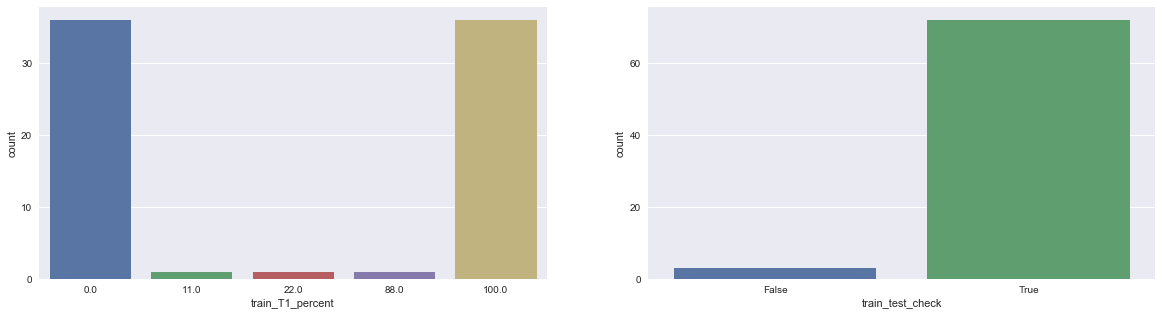

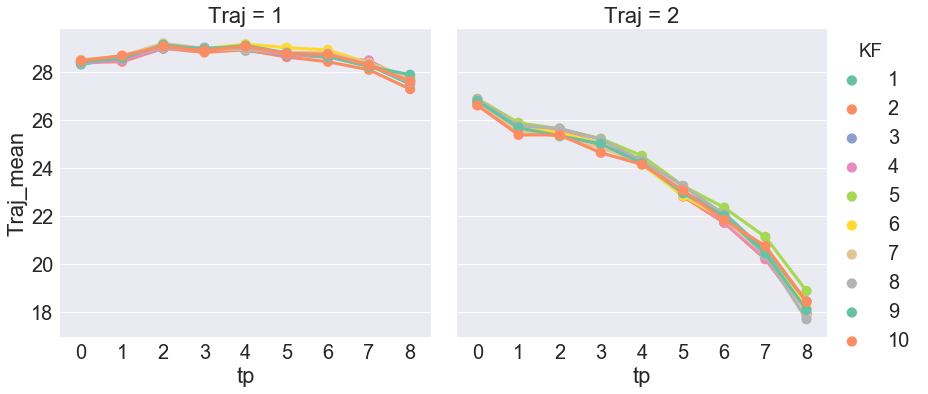

In [5]:
# Cluster Stability 
CS_cols = []
for tp in timepoints:
    CS_cols.append(cs_scale+'_'+tp)
    
clust_df = test_merge[CS_cols]
subject_index_col_name = 'PTID'
similarity_metric = 'euclidean' #'euclidean' #correlation
test_dist_metric = similarity_metric
linkage_metric = 'ward'

subx = len(clust_df.index)
n_folds = 10
kf_traj_df, KF_traj_stats, KF_class_distribution, traj_permute_stats, traj_templates = KFold_clustering_stability(clust_df,subject_index_col_name,similarity_metric,
                                                                                                  linkage_metric,test_dist_metric,n_folds)

train_test_check_vals = traj_permute_stats['train_test_check'].values

# Plot distribution of Traj_1 distribution  
plt.rcParams['figure.figsize'] = (20, 5)
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.set(font_scale=2) 
sns.countplot(x = 'train_T1_percent', data=traj_permute_stats, ax=ax1)
g = sns.countplot(x = 'train_test_check', data=traj_permute_stats, ax=ax2)

print 'train_test_check % = {}'.format(np.sum(train_test_check_vals)/float(len(train_test_check_vals)))

#Plot Trajectories over KF
KF_class_dist_df = pd.DataFrame.from_dict(KF_class_distribution,orient='index')
print 'T1 counts: {}, T2: counts: {}'.format(KF_class_dist_df['train_T1_count'].values,KF_class_dist_df['train_T2_count'].values)

print traj_templates

KF_traj_stats_df = pd.DataFrame.from_dict(KF_traj_stats,orient='index')
sns.factorplot(y='Traj_mean', x='tp', hue='KF', kind='point', col='Traj' ,palette='Set2',data=KF_traj_stats_df,size=6)
#sns.factorplot(y='Traj_mean', x='tp', hue='Traj', kind='box',palette='Set2',data=KF_traj_stats_df,size=8)

In [19]:
# 2. Assign trajectory labels to all remaining subjects in ADNI1 and ADNI2 and AIBL
# Template timepoints = ['bl','m06','m12','m18','m24','m36','m48','m60','m72']
save_trajectory_labels = False

#ADNI1and2 subjects (no ADNI 3T here)
adni_tp = timepoints #['bl','m12','m18','m24','m36']
adni_tp_vector = 'auto_select' #np.arange(len(timepoints))#[0,1,2,3,4]

print 'number of timepoints: {}'.format(len(adni_tp_vector))
dx_col = 'DX_bl'
col_list_feat = ['PTID', cs_scale]
demo_cols = ['PTID','ORIGPROT','AGE','PTGENDER','APOE4','DX_bl','FLDSTRENG']
keep_rows_with_DX = ['CN','NL','SMC','EMCI','LMCI','AD']
drop_rows_with_val = -1
remove_NaNs = False  #keeping all subjects and later filtering them based on how many CS_tps they have (need at least 4)

cohorts = ['ADNI1','ADNI2','ADNIGO']
adni_demo_data = adnimerge_custom_data[(adnimerge_custom_data.ORIGPROT.isin(cohorts))&(adnimerge_custom_data.VISCODE == 'bl')][demo_cols]
adni_cs_data = adnimerge_custom_data[(adnimerge_custom_data.ORIGPROT.isin(cohorts))][['PTID','VISCODE',cs_scale]] 

test_merge = create_longitudinal_CS_df(adni_demo_data, dx_col, adni_cs_data, cs_scale, col_list_feat, adni_tp, keep_rows_with_DX, drop_rows_with_val,remove_NaNs)

CS_cols = []
for tp in adni_tp:
    CS_cols.append(cs_scale+'_'+tp)
    
adni_df = test_merge[demo_cols+CS_cols]
print '# of subs: {}'.format(len(adni_df))
adni_df['nan_rows'] = adni_df.isnull().sum(axis=1).values

min_cs_tps = 4
adni_df_4cstp = adni_df[adni_df['nan_rows']<=len(adni_tp_vector)-min_cs_tps]
print '# of subs with at least {} timepoints: {}'.format(min_cs_tps,len(adni_df_4cstp))

adni_traj_classes, adni_traj_dist = getTrajClass(list(adni_df_4cstp[CS_cols].values), traj_templates, adni_tp_vector, similarity_metric)

adni_df_4cstp['traj'] = adni_traj_classes

#Store template creating subjects to a file
if save_trajectory_labels:    
    baseline_dir = '/projects/nbhagwat/Traj_prediction/ADNI/exp_setup/'
    print 'Saving traj labels at :{}'.format(baseline_dir)
    adni_df_4cstp.to_csv(baseline_dir + 'ADNI_trajectory_labels_MMSE_4cstp_autoselect.csv')
    


number of timepoints: 11
# bl: 1737
# rows with val bl (-1 rows removed): 1736
# m06: 1737
# rows with val m06 (-1 rows removed): 1736
# m12: 1737
# rows with val m12 (-1 rows removed): 1736
# m18: 1737
# rows with val m18 (-1 rows removed): 1736
# m24: 1737
# rows with val m24 (-1 rows removed): 1736
# m36: 1737
# rows with val m36 (-1 rows removed): 1736
# m48: 1736
# rows with val m48 (-1 rows removed): 1735
# m60: 1736
# rows with val m60 (-1 rows removed): 1735
# m72: 1735
# rows with val m72 (-1 rows removed): 1734
# (DX: ['CN', 'NL', 'SMC', 'EMCI', 'LMCI', 'AD']) kept): 1728
# (dups removed): 1728
Keeping rows with NaNs
# of subs: 1728
# of subs with at least 4 timepoints: 1624
selecting tp_vector based on available score tps


/mnt/tigrlab/projects/nbhagwat/ADNI_prediction/code/conda_envs/AD_traj/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [48]:
# Create AIBL long data
#['bl','m06','m12','m18','m24','m36','m48','m60','m72']
dx_col = 'DX_bl'
cs_scale = 'MMSE'
demo_cols = ['RID','PTGENDER','DX_bl','PTDOB']
col_list_feat = ['RID', cs_scale]
keep_rows_with_DX = [1,2]
aibl_tp = ['bl','m18','m36','m54']
aibl_tp_vector = [0,3,5,6]
drop_rows_with_val = -4
remove_NaNs = False  #keeping all subjects and later filtering them based on how many CS_tps they have (need at least 4)

#aibl_demo_data = pd.merge(aibl_demo_data,aibl_dx_bl_data,on='RID',how='inner')
aibl_demo_data.rename(columns={'DX_bl_x': 'DX_bl'},inplace=True)
aibl_cs_data = aibl_mmse_data.rename(columns={'MMSCORE': 'MMSE'})

test_merge = create_longitudinal_CS_df(aibl_demo_data, dx_col, aibl_cs_data, cs_scale, col_list_feat, aibl_tp, keep_rows_with_DX,drop_rows_with_val,remove_NaNs)

CS_cols = []
for tp in aibl_tp:
    CS_cols.append(cs_scale+'_'+tp)

aibl_df = test_merge[demo_cols+CS_cols]
print '# of subs: {}'.format(len(aibl_df))
aibl_df['nan_rows'] = aibl_df.isnull().sum(axis=1).values

aibl_df_3cstp = aibl_df[aibl_df['nan_rows']<=0]
print '# of subs with at least {} timepoints: {}'.format(3,len(aibl_df_3cstp))

aibl_traj_classes, albl_traj_dist = getTrajClass(list(aibl_df_3cstp[CS_cols].values), traj_templates, aibl_tp_vector, similarity_metric)

aibl_df_3cstp['traj'] = aibl_traj_classes

# bl: 861
# rows with val bl (-4 rows removed): 860
# m18: 860
# rows with val m18 (-4 rows removed): 858
# m36: 860
# rows with val m36 (-4 rows removed): 858
# m54: 859
# rows with val m54 (-4 rows removed): 858
# (DX: [1, 2]) kept): 747
# (dups removed): 747
Keeping rows with NaNs
# of subs: 747
# of subs with at least 3 timepoints: 132
using fixed tp vector of size: 4


/data/chamal/projects/nikhil/code/python/conda/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/data/chamal/projects/nikhil/code/python/conda/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


678 946


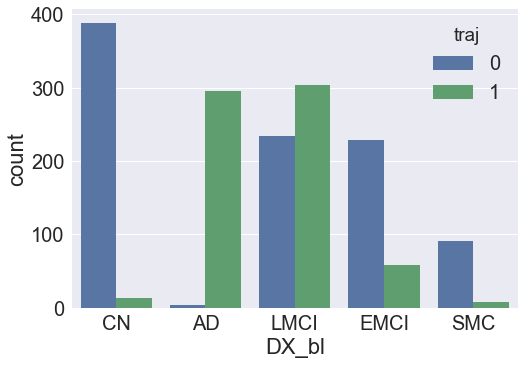

In [20]:
print np.sum(adni_df_4cstp['traj'].values==1), np.sum(adni_df_4cstp['traj'].values==0)
g = sns.countplot(x='DX_bl', hue='traj',data=adni_df_4cstp)
#g = sns.factorplot(y='AGE', x='DX_bl', hue='traj', col='ORIGPROT', kind='box', data=adni_df_4cstp, size=10)

In [1]:
print 'Traj1, aibl, adni,total: {},{},{}'.format(np.sum(aibl_df_3cstp.traj==1), np.sum(adni_df_4cstp.traj==1),
                                                np.sum(aibl_df_3cstp.traj==1)+np.sum(adni_df_4cstp.traj==1)) 
print 'Traj2, aibl, adni,total: {},{},{}'.format(np.sum(aibl_df_3cstp.traj==2), np.sum(adni_df_4cstp.traj==2),
                                                np.sum(aibl_df_3cstp.traj==2)+np.sum(adni_df_4cstp.traj==2)) 
                                                


NameError: name 'np' is not defined

In [21]:
adni_traj_classes

[0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
